In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
stock = pd.read_csv("stocks_data/NAVER.csv")
stock = stock.set_index(keys=['Date'], inplace=False, drop=True)

In [19]:
#stock = stock.iloc[600:]

In [20]:
pd.isnull(stock).sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

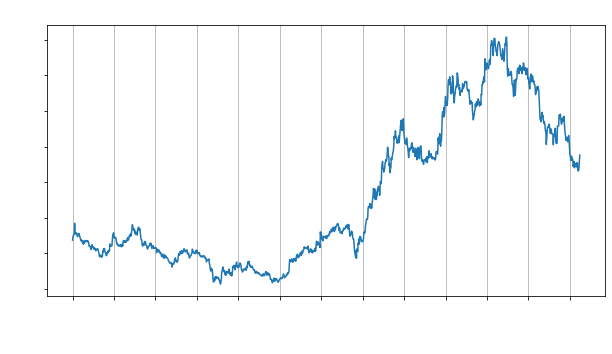

In [21]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize = (10,5))
ax = plt.subplot()
plt.title("종가(2017-06-01~2022-06-01)", fontsize=15, color = 'white')
plt.plot(stock['Close'], "-", label="Close")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.show()

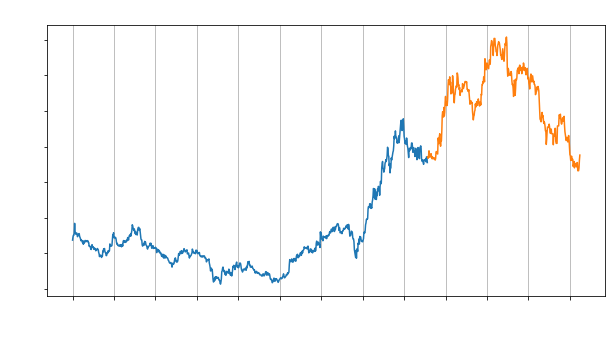

In [22]:
y_train = stock['Close'][:int(0.7*len(stock))]
y_test = stock['Close'][int(0.7*len(stock)):]

plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots(figsize = (10,5))
plt.title("종가(2017-06-01~2022-06-01)", fontsize=15, color = 'white')
ax.plot(y_train)
ax.plot(y_test)
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
ax.xaxis.set_major_locator(plt.MultipleLocator(100))
plt.xticks(rotation=45)
plt.grid(axis = 'x')

In [23]:
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [24]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d = n_diffs            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1 # 계절적 차분이 필요할 때 사용, 분기별이면 4, 월별이면 12, 계절적 특징 없으면 1
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True # 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부,
                                        # False면 모든 모수 조합으로 모형을 적합한다.
                      , trace=True # stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16616.793, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16618.407, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16618.411, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16615.678, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16619.718, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.534 seconds


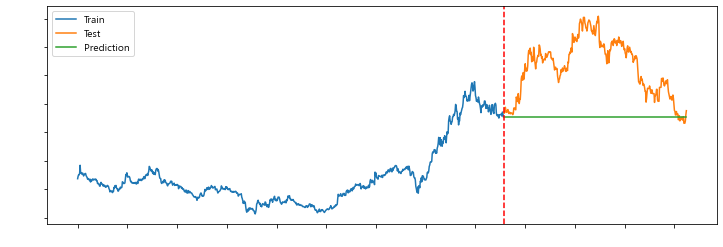

In [25]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.axvline(x=len(y_train), c='r', linestyle='--')
axes.xaxis.set_major_locator(plt.MultipleLocator(100))
plt.legend()
plt.show()

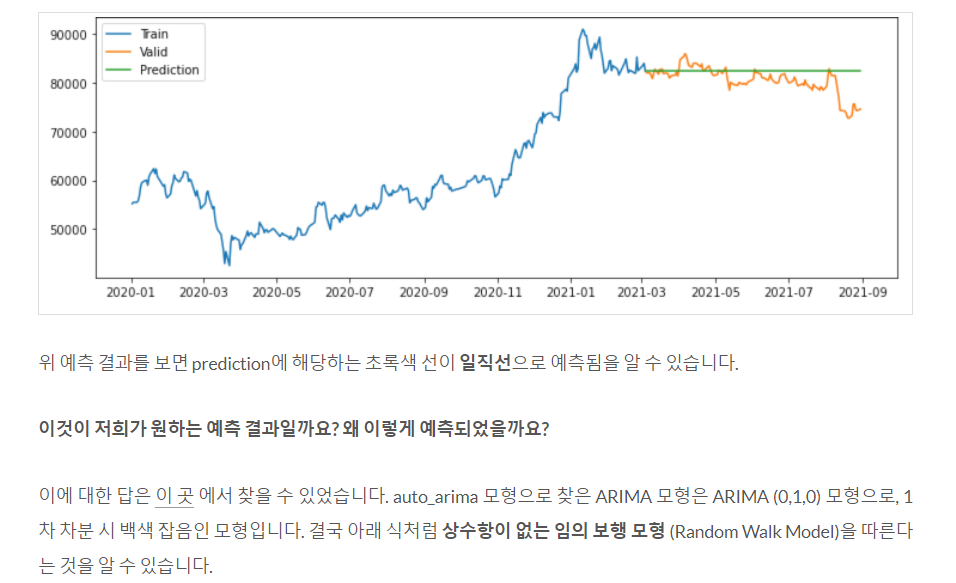

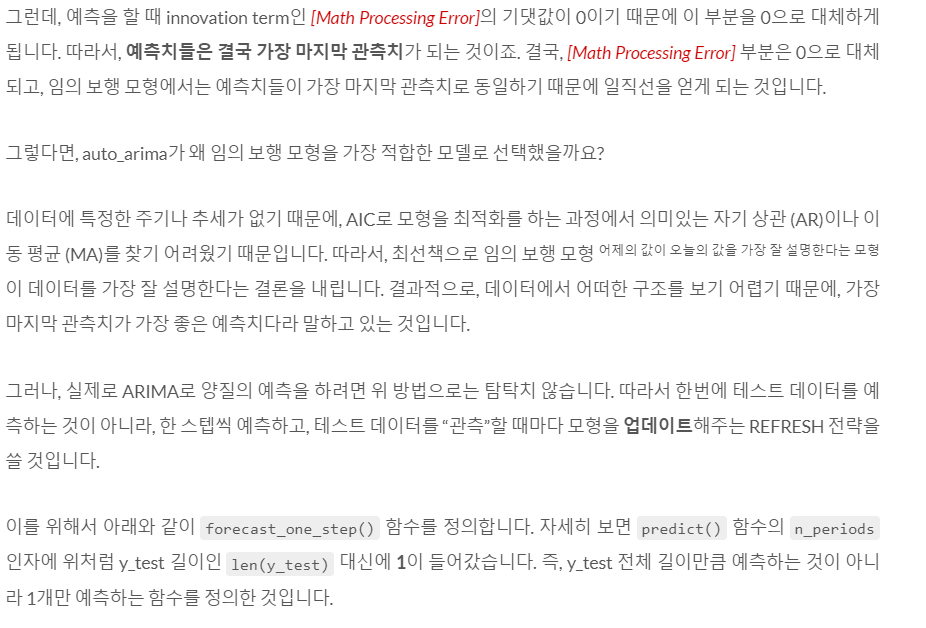

직선 예측을 피하기 위해 한 스텝씩 예측

In [26]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

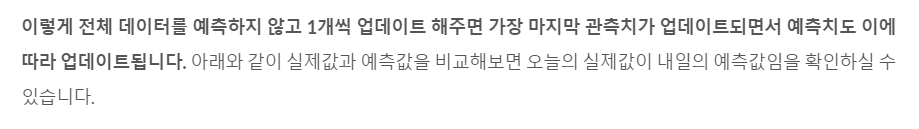

In [27]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [28]:
pd.DataFrame({"test": y_test, "pred": y_pred}).head(20)

,test,pred
Date,,
2020-12-01,285500.0,277500.0
2020-12-02,283500.0,285500.0
2020-12-03,287000.0,283500.0
2020-12-04,294000.0,287000.0
2020-12-07,289500.0,294000.0
2020-12-08,285000.0,289500.0
2020-12-09,288000.0,285000.0
2020-12-10,286000.0,288000.0
2020-12-11,290000.0,286000.0


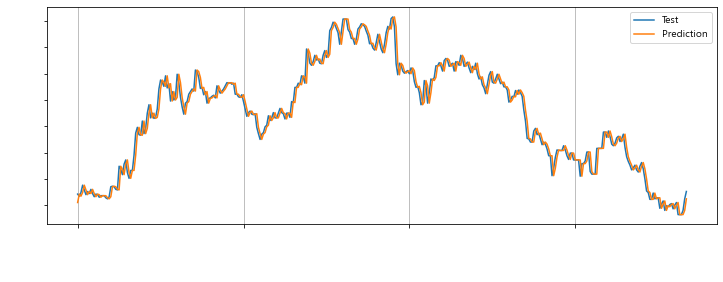

In [29]:
fig, axes = plt.subplots(figsize=(12, 4))
#axes.plot(y_train, label='Train')        # 훈련 데이터
axes.plot(y_test, label='Test')          # 테스트 데이터
axes.plot(y_test.index, y_pred, label='Prediction')  # 예측 데이터
axes.xaxis.set_major_locator(plt.MultipleLocator(100))
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.legend()
plt.show()

성능 검증

In [30]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

def MPE(y_test, y_pred): 
    return np.mean((y_test - y_pred) / y_test) * 100
print(f"MPE: {MPE(y_test, y_pred):.3f}")

def MAE(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

print(f"MAE: {MAE(y_test, y_pred):.3f}")

def MSE(y_test, y_pred):
    return np.mean(np.square((y_test - y_pred)))

print(f"MSE: {MSE(y_test, y_pred):.3f}")

print(f"RMSE: {np.sqrt(MSE(y_test, y_pred)):.3f}")

MAPE: 1.489
MPE: -0.011
MAE: 5379.076
MSE: 54545516.304
RMSE: 7385.494
